In [ ]:
%%bash
data_path=/content/drive/MyDrive/vkr/second_practice/fires_data
# unzip $data_path/non_fires.zip
# unzip $data_path/forest_fires.zip
# cp $data_path/Irkutsk_region.geojson .
cp -r $data_path/train_data .

In [ ]:
!pip install graphviz

In [ ]:
# !pip install mapclassify
import geopandas as gpd
import folium

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz

from calendar import monthrange
import os, json

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import scipy.stats as st


In [ ]:
train_files_path = "train_data/"

##### Do not run

In [ ]:
features, target.hist()

NameError: name 'features' is not defined

In [ ]:
X_train_ds, X_val_ds, y_train_ds, y_val_ds = train_test_split(features, target, test_size=0.33, random_state=64)
X_train_ds.head(5), y_train_ds.head(5)

In [ ]:
# prepare the test dataset

train_ds_cols = train_ds.columns
test_ds_ = test_ds.loc[:, test_ds.columns.isin(train_ds_cols)]
print(test_ds_.columns, test_ds_.head(1))
test_ds_.is_fire.hist()

X_test_ds = test_ds_.loc[:, ~test_ds_.columns.isin(["is_fire"])]
print(X_test_ds.columns)
# arrange X_test_ds so that its columns order corresponds to the X_train_ds (carefull! pd.DataFrame)
X_test_ds = X_test_ds.reindex(X_train_ds.columns, axis="columns")
# assert that no NaN columns appeared after the reindex
assert X_test_ds.isnull().sum().sum() == 0
y_test_ds = test_ds_.loc[:, "is_fire"]

# normalize X_test using z-score (like X_train)
X_test_ds = (X_test_ds - X_test_ds.mean()) / X_test_ds.std()

print(X_test_ds.head(2), y_test_ds, sep="\n")

In [ ]:
# convert x and y train, validation and test datasets to numpy arrays
l = [X_train_ds, y_train_ds, X_val_ds, y_val_ds, X_test_ds, y_test_ds]
# !!! Attention: preserve the order, it's important
X_train, y_train, X_val, y_val, X_test, y_test = map(lambda x: x.to_numpy(), l)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
assert X_train.shape[1] == X_val.shape[1]
assert X_train.shape[1] == X_test.shape[1]
# transpose y so that it works with the keras methods
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
from tensorflow.keras import regularizers as rg
rg.L1()
input_shape = (X_train.shape[1], )
print("Model input shape:", input_shape)
model = Sequential()
model.add(Input(input_shape))
# model.add(Dense(256, activation="relu"))
# model.add(Dense(128, activation="relu", kernel_regularizer=rg.L1(0.01)))
# model.add(Dense(64, activation="relu",  kernel_regularizer=rg.L1(0.01)))
model.add(Dense(512, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
model.add(Dense(64, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
model.add(Dense(8, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "f1_score"]) #, "precision", "recall", "f1_score", "auc"])
tf.keras.utils.plot_model(
    model=model, to_file="a.png",
    show_layer_activations=True, show_layer_names=True, show_shapes=True,
    dpi=100
)
# a = tf.keras.utils.vis_utils.model_to_dot(model=model, show_layer_activations=True, show_layer_names=True, show_shapes=True, )

In [ ]:
model.optimizer.learning_rate.assign(0.0001)
callback_ = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", start_from_epoch=3)
# to validate provide either the validation_data = (x_val, y_val) or the validation_split = (float)
# if both provided the validation_data overrides the validation_split
model.fit(
    X_train, y_train,
    batch_size=64, epochs=100,
    # validation_split=0.2,
    validation_data=[X_val, y_val],
    callbacks=callback_,
)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred = (y_pred > 0.5)
print(y_pred.shape)
np.unique(y_pred)

In [ ]:
print(classification_report(y_test, y_pred.astype(int)))
cm = confusion_matrix(y_test, y_pred.astype(int))
sns.heatmap(cm, annot=True, fmt="g")

In [ ]:
# 60 epochs, batch_size = 64, train:val split = 0.25
# 3 layers 0.66 0.74, 0.69
# 2 layers 0.69 0.57 0.72
# 2 layers + L1 0.64 0.72 0.68
# 1 layer 0.71 0.72 0.71

# 100 ep, batch_size = 64, split = 0.25
# 2 layers 0.68 0.74 0.71

# 100 ep batch = 64 split = 0.33 r_state = 64
# 3 layers 0.72 0.76 0.74
# 3 layers + L1 (0.001)  0.69 0.75 0.72
# 3 layers + L1 + L1 0.56 0.69 0.63
# 3 layers + L1 + L1 + L1 0.49 0.66 0.57
# 3 layers + L2 + L2 + L2 0.65 0.74 0.69
# 3 layers + L1L2 + L1L2 + L1L2(0.01, 0.01) 0.56 0.69 0.63

# above is regs on kernel

# below is regs on output
# 100 ep batch = 64 split = 0.33 r_state = 64
# 3 layers + L1L2 + L1L2 + L1L2(0.01, 0.001) stopped
# 3 layers + L1 + L1 + L1(0.01) stopped
# 3 layers + L2 + L2 + L2(0.01) 0.76 0.58 0.67

# below is regs on bias
# 100 ep batch = 64 split = 0.33 r_state = 64
# 3 layers (512, 64, 8) + bias + L2 + L2 + L2(0.01) 0.73 0.77 0.75

#

In [ ]:
print(classification_report(y_test, y_pred.astype(int)))
cm = confusion_matrix(y_test, y_pred.astype(int))
sns.heatmap(cm, annot=True, fmt="g")

##### Train with all features

In [ ]:
# read the test dataset and drop columns to correspond to the training dataset
test_ds = pd.read_csv(train_files_path + "test_dataset_2024.csv", sep=";").drop(columns=["Unnamed: 0"])
test_ds["vegetation_type"] = test_ds["vegetation_type"].astype(int)
print(test_ds.dtypes, test_ds.head(5))

year                 int64
is_fire              int64
T                  float64
RH                 float64
WIND_DIR_STD       float64
WIND_SPEED         float64
APCP               float64
elevation          float64
slope              float64
aspect             float64
vegetation_type      int64
road_dist          float64
river_dist         float64
locality_dist      float64
techno_obj_dist    float64
dtype: object    year  is_fire          T         RH  WIND_DIR_STD  WIND_SPEED      APCP  \
0  2024        1  16.133750  50.912500    129.970944    1.725000  0.025000   
1  2024        1  24.109375  46.468750    119.376992    2.028125  0.025000   
2  2024        1  23.584375  47.534375    141.419912    2.093750  0.015625   
3  2024        1  19.822812  57.487500    100.166043    1.984375  0.118750   
4  2024        1  24.206562  40.284375     67.711544    2.431250  0.025000   

    elevation     slope      aspect  vegetation_type      road_dist  \
0  351.109375  0.862569  217.516313      

In [ ]:
train_ds = pd.read_csv(train_files_path + "dataset.csv", sep=";").drop(columns=["Unnamed: 0"])
print(train_ds.dtypes, train_ds.shape, train_ds.columns, train_ds.index, sep="\n")
train_ds.head(5)

T                  float64
RH                 float64
WIND_DIR_STD       float64
WIND_SPEED         float64
APCP               float64
elevation          float64
slope              float64
aspect             float64
road_dist          float64
river_dist         float64
locality_dist      float64
techno_obj_dist    float64
vegetation_type      int64
is_fire              int64
dtype: object
(18314, 14)
Index(['T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
       'aspect', 'road_dist', 'river_dist', 'locality_dist', 'techno_obj_dist',
       'vegetation_type', 'is_fire'],
      dtype='object')
RangeIndex(start=0, stop=18314, step=1)


,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,road_dist,river_dist,locality_dist,techno_obj_dist,vegetation_type,is_fire
0,1.117702,-0.480393,0.952862,-0.216407,0.839897,0.592592,0.391917,0.603082,-0.106400,-0.129627,0.926929,2.392782,21,1
1,0.910026,-0.708636,1.047870,-1.378062,-0.411450,0.726857,0.646070,1.177261,0.072706,-0.066609,2.805027,1.691132,1,1
2,-0.929746,0.385106,1.468098,-0.042440,-0.603488,-0.265768,1.565744,1.537563,0.314132,-1.025357,2.144765,1.116375,11,1
3,-0.843529,0.329279,1.863494,0.120304,-0.572514,-0.262266,0.029107,0.466084,0.465508,0.044484,1.428999,0.912215,15,1
4,1.208797,-0.599954,0.317706,-0.421694,-0.283758,1.094569,1.091687,0.581935,0.483859,-0.405281,1.718110,0.913903,1,1


Index([ 1097,  1098,  1099,  1100,  1101,  1102,  1103,  1104,  1105,  1106,
       ...
       18304, 18305, 18306, 18307, 18308, 18309, 18310, 18311, 18312, 18313],
      dtype='int64', length=10653)
2777 18314
(2777,)


(is_fire
 0    7876
 1    7661
 Name: count, dtype: int64,
 <Axes: >)

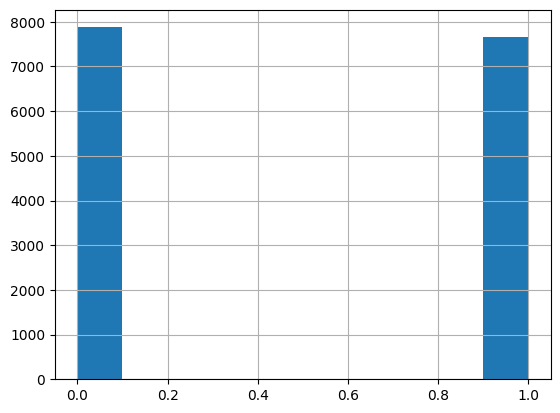

In [ ]:
# drop nonfires
drop_nonfires_idx = train_ds[(train_ds.is_fire == 0)].index
assert drop_nonfires_idx.duplicated().sum() == 0
print(drop_nonfires_idx)
idx = drop_nonfires_idx.to_numpy()
np.random.shuffle(idx)
vc = train_ds.is_fire.value_counts()
a = -215
diff = vc[0] - vc[1] + a
print(diff, train_ds.shape[0])
drop_idx = idx[:diff]
print(drop_idx.shape)

train_ds = train_ds.drop(index=drop_idx)
train_ds.is_fire.value_counts(), train_ds.is_fire.hist()

In [ ]:
features = train_ds.loc[:, ~train_ds.columns.isin(["is_fire"])]
target = train_ds["is_fire"]
features.head(1), target

(          T        RH  WIND_DIR_STD  WIND_SPEED      APCP  elevation  \
 0  1.117702 -0.480393      0.952862   -0.216407  0.839897   0.592592   
 
       slope    aspect  road_dist  river_dist  locality_dist  techno_obj_dist  \
 0  0.391917  0.603082    -0.1064   -0.129627       0.926929         2.392782   
 
    vegetation_type  
 0               21  ,
 0        1
 1        1
 2        1
 3        1
 4        1
         ..
 18309    0
 18310    0
 18311    0
 18312    0
 18313    0
 Name: is_fire, Length: 15537, dtype: int64)

<Axes: >

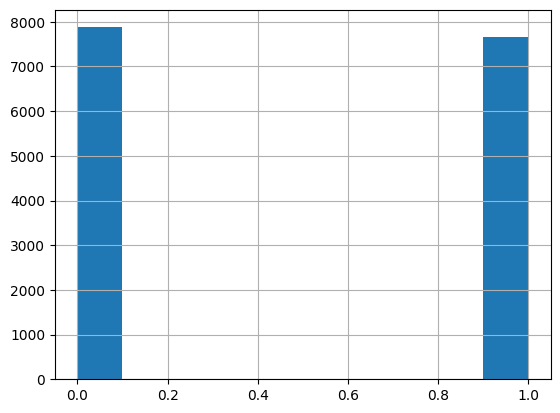

In [ ]:
features = features.reset_index(drop=True)
target = target.reset_index(drop=True)
target.hist()

In [ ]:
# lets test if vegetation type normalization works
# from sklearn.preprocessing import MinMaxScaler
# import scipy

# # plt.hist(features.vegetation_type)
# sc = MinMaxScaler()
# vt = features.vegetation_type.to_numpy().reshape(-1, 1)
# tr = sc.fit_transform(vt).reshape(1, -1)[0]
# transform_ = tr

# transform_ = scipy.special.boxcox1p(tr, 3)
# print(transform_)
# plt.hist(transform_)

vt = features.vegetation_type
transform_ = (vt - vt.mean()) / vt.std()
# transform_ = vt

In [ ]:
# ex_cols = ["RH", "techno_obj_dist"]
# features_ex = features.loc[:, ~features.columns.isin(ex_cols)]
features_ex = features.copy()
features_ex.vegetation_type = transform_
features_ex.columns, #features_ex.vegetation_type

(Index(['T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
        'aspect', 'road_dist', 'river_dist', 'locality_dist', 'techno_obj_dist',
        'vegetation_type'],
       dtype='object'),)

In [ ]:
# randomly permute train dataset
# rand_idx = np.random.permutation(len(features_ex))
# print(rand_idx)
# # Carefull !!! iloc, that doesn't mean that index will correspond, check if it's not the RangeIndex
# features_ex = features_ex.iloc[rand_idx]
# target = target.iloc[rand_idx]

In [ ]:
features_ex, target

(              T        RH  WIND_DIR_STD  WIND_SPEED      APCP  elevation  \
 0      1.117702 -0.480393      0.952862   -0.216407  0.839897   0.592592   
 1      0.910026 -0.708636      1.047870   -1.378062 -0.411450   0.726857   
 2     -0.929746  0.385106      1.468098   -0.042440 -0.603488  -0.265768   
 3     -0.843529  0.329279      1.863494    0.120304 -0.572514  -0.262266   
 4      1.208797 -0.599954      0.317706   -0.421694 -0.283758   1.094569   
 ...         ...       ...           ...         ...       ...        ...   
 15532 -0.739814  0.747218      0.252631    0.316719 -0.473398  -0.388975   
 15533 -0.386020  1.069264     -0.606648    1.489598  0.449625   0.167846   
 15534  1.084118 -1.646481      1.484304   -0.356704 -0.337112  -0.585089   
 15535  0.711522 -0.187400      0.071249   -1.052574 -0.207022   0.476024   
 15536  0.683547 -0.006059      0.546301   -0.620461  0.059354  -0.728672   
 
           slope    aspect  road_dist  river_dist  locality_dist  \
 0    

(          T        RH  WIND_DIR_STD  WIND_SPEED      APCP  elevation  \
 0  1.117702 -0.480393      0.952862   -0.216407  0.839897   0.592592   
 1  0.910026 -0.708636      1.047870   -1.378062 -0.411450   0.726857   
 2 -0.929746  0.385106      1.468098   -0.042440 -0.603488  -0.265768   
 3 -0.843529  0.329279      1.863494    0.120304 -0.572514  -0.262266   
 4  1.208797 -0.599954      0.317706   -0.421694 -0.283758   1.094569   
 
       slope    aspect  road_dist  river_dist  locality_dist  techno_obj_dist  \
 0  0.391917  0.603082  -0.106400   -0.129627       0.926929         2.392782   
 1  0.646070  1.177261   0.072706   -0.066609       2.805027         1.691132   
 2  1.565744  1.537563   0.314132   -1.025357       2.144765         1.116375   
 3  0.029107  0.466084   0.465508    0.044484       1.428999         0.912215   
 4  1.091687  0.581935   0.483859   -0.405281       1.718110         0.913903   
 
    vegetation_type  
 0         1.475893  
 1        -2.364461  
 2    

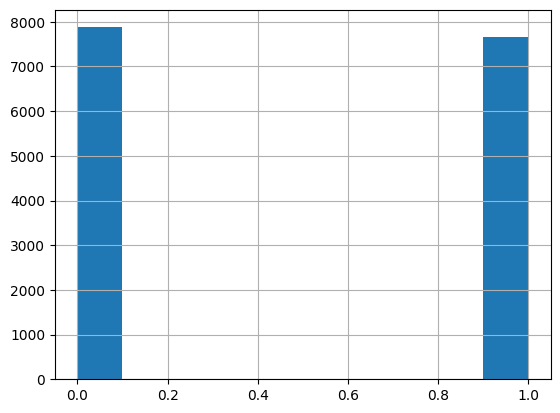

In [ ]:
# X_train_ds, X_val_ds, y_train_ds, y_val_ds = train_test_split(features_ex, target, test_size=0.1, random_state=4)
X_train_ds = features_ex.copy()
y_train_ds = target.copy()
X_train_ds.head(5), y_train_ds.head(5), X_train_ds.shape, y_train_ds.shape, y_train_ds.hist()

Index(['is_fire', 'T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation',
       'slope', 'aspect', 'vegetation_type', 'road_dist', 'river_dist',
       'locality_dist', 'techno_obj_dist'],
      dtype='object')    is_fire         T       RH  WIND_DIR_STD  WIND_SPEED   APCP   elevation  \
0        1  16.13375  50.9125    129.970944       1.725  0.025  351.109375   

      slope      aspect  vegetation_type      road_dist    river_dist  \
0  0.862569  217.516313               18  422363.693609  40989.628659   

   locality_dist  techno_obj_dist  
0  139923.175317    772714.174606  
Index(['T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
       'aspect', 'vegetation_type', 'road_dist', 'river_dist', 'locality_dist',
       'techno_obj_dist'],
      dtype='object')
****************************************************************************************************
Normalization
          T        RH  WIND_DIR_STD  WIND_SPEED      APCP  elevation  \
0  0.711783 

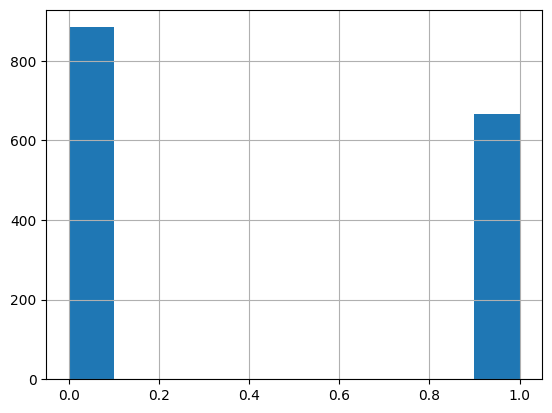

In [ ]:
# prepare the test dataset

train_ds_cols = train_ds.columns
test_ds_ = test_ds.loc[:, test_ds.columns.isin(train_ds_cols)]
print(test_ds_.columns, test_ds_.head(1))
test_ds_.is_fire.hist()

X_test_ds = test_ds_.loc[:, ~test_ds_.columns.isin(["is_fire"])]
print(X_test_ds.columns)
# arrange X_test_ds so that its columns order corresponds to the X_train_ds (carefull! pd.DataFrame)
X_test_ds = X_test_ds.reindex(X_train_ds.columns, axis="columns")
# assert that no NaN columns appeared after the reindex
assert X_test_ds.isnull().sum().sum() == 0
y_test_ds = test_ds_.loc[:, "is_fire"]

# normalize X_test using z-score (like X_train)
# X_test_ds = (X_test_ds - X_test_ds.mean()) / X_test_ds.std()
print("*" * 100, "Normalization", sep="\n")
without_vt = X_test_ds.loc[:, ~X_test_ds.columns.isin(["vegetation_type"])]
without_vt = (without_vt - without_vt.mean()) / without_vt.std()
vt = X_test_ds.vegetation_type
vt = (vt - vt.mean()) / vt.std()
X_test_ds = without_vt.join(vt)

print(X_test_ds.head(2), y_test_ds, sep="\n")

In [ ]:
# permute test dataset
rand_idx_test = np.random.permutation(len(X_test_ds))
X_test_ds = X_test_ds.iloc[rand_idx_test]
y_test_ds = y_test_ds.iloc[rand_idx_test]

In [ ]:
X_test_ds.head(5), y_test_ds.head(5)

(             T        RH  WIND_DIR_STD  WIND_SPEED      APCP  elevation  \
 10    1.253791 -1.729603      0.814846   -1.047733 -1.189068  -0.881865   
 978   0.648748 -1.129997      1.314481   -0.117685 -0.081443   0.867592   
 1546 -1.154693  1.209399     -0.446190    0.559157  0.502216  -0.531506   
 863  -0.798752  0.319799     -0.675021    0.174477 -0.459494   0.805337   
 185   0.269337 -1.318202      0.032590    1.026616 -0.923769  -0.529685   
 
          slope    aspect  road_dist  river_dist  locality_dist  \
 10   -0.817966 -0.368256   0.954027    0.750301       0.259070   
 978  -0.061021 -1.843422   0.664465   -0.276526       1.667625   
 1546 -0.819760  1.543758   1.633741    1.551106       0.790505   
 863   0.019829  0.699423  -0.453489   -0.480843      -0.417241   
 185  -0.411904 -0.618330  -0.805838   -0.284332      -1.105717   
 
       techno_obj_dist  vegetation_type  
 10           3.350543         0.814911  
 978          0.284463        -1.657739  
 1546       

In [ ]:
# if validation dataset is unavailable
# convert x and y train, validation and test datasets to numpy arrays
l = [X_train_ds, y_train_ds, X_test_ds, y_test_ds]
# !!! Attention: preserve the order, it's important
X_train, y_train, X_test, y_test = map(lambda x: x.to_numpy(), l)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
assert X_train.shape[1] == X_test.shape[1]
# transpose y so that it works with the keras methods
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape, y_test.shape)

(15537, 13) (15537,) (1550, 13) (1550,)
(15537, 1) (1550, 1)


In [ ]:
# comment if the validation dataset is not available

# # convert x and y train, validation and test datasets to numpy arrays
# l = [X_train_ds, y_train_ds, X_val_ds, y_val_ds, X_test_ds, y_test_ds]
# # !!! Attention: preserve the order, it's important
# X_train, y_train, X_val, y_val, X_test, y_test = map(lambda x: x.to_numpy(), l)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
# assert X_train.shape[1] == X_val.shape[1]
# assert X_train.shape[1] == X_test.shape[1]
# # transpose y so that it works with the keras methods
# y_train = y_train.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
# print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
512 * 8

4096

Model input shape: (13,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,529 (158.32 KB)

 Trainable params: 40,529 (158.32 KB)

 Non-trainable params: 0 (0.00 B)

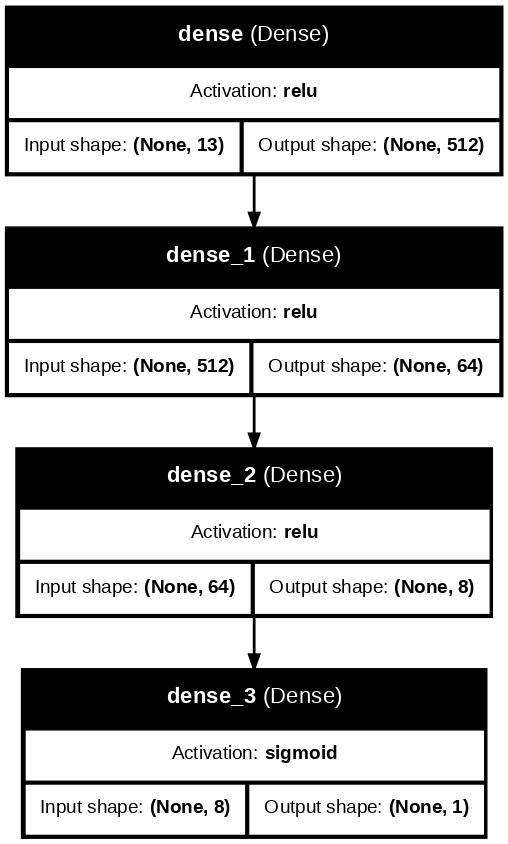

In [ ]:
from tensorflow.keras import regularizers as rg


input_shape = (X_train.shape[1], )
print("Model input shape:", input_shape)
model = Sequential()
model.add(Input(input_shape))

model.add(Dense(512, activation="relu", bias_regularizer=rg.L2(0.01))) #, kernel_regularizer=rg.L2(0.01)))
model.add(Dense(64, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
model.add(Dense(8, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation="sigmoid"))

model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "f1_score", tf.metrics.AUC()]) #, "precision", "recall", "f1_score", "auc"])
tf.keras.utils.plot_model(
    model=model, to_file="arch.png",
    show_layer_activations=True, show_layer_names=True, show_shapes=True,
    dpi=100
)
# a = tf.keras.utils.vis_utils.model_to_dot(model=model, show_layer_activations=True, show_layer_names=True, show_shapes=True, )

In [ ]:
model.optimizer.learning_rate.assign(0.0001)
callback_ = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", start_from_epoch=3)
# to validate provide either the validation_data = (x_val, y_val) or the validation_split = (float)
# if both provided the validation_data overrides the validation_split
model.fit(
    X_train, y_train,
    batch_size=64, epochs=100,
    validation_split=0.3,
    # validation_data=[X_val, y_val],
    callbacks=callback_,
)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7037 - auc: 0.7693 - f1_score: 0.6723 - loss: 0.6004 - val_accuracy: 0.7136 - val_auc: 0.7892 - val_f1_score: 0.6432 - val_loss: 0.5588
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7785 - auc: 0.8597 - f1_score: 0.6590 - loss: 0.4680 - val_accuracy: 0.7415 - val_auc: 0.8200 - val_f1_score: 0.6432 - val_loss: 0.5208
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8049 - auc: 0.8879 - f1_score: 0.6711 - loss: 0.4259 - val_accuracy: 0.7585 - val_auc: 0.8441 - val_f1_score: 0.6432 - val_loss: 0.4927
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8220 - auc: 0.9019 - f1_score: 0.6705 - loss: 0.4006 - val_accuracy: 0.7748 - val_auc: 0.8610 - val_f1_score: 0.6432 - val_loss: 0.4728
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8266 - auc: 0.9091 - f1_score: 0.6678 - loss: 0.3841 - val_accuracy: 0.7769 - val_auc: 0.8650 - val_f1_score: 0.6432 - 

In [ ]:
# X_test = np.concatenate((X_test, X_train[-1000:]), axis=0)
# y_test = np.concatenate((y_test, y_train[-1000:]), axis=0)

In [ ]:
model.evaluate(X_test, y_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8174 - auc: 0.9016 - f1_score: 0.5869 - loss: 0.3907


[0.42037078738212585,
 0.8038709759712219,
 0.601082980632782,
 0.8880013823509216]

In [ ]:
model.metrics_names

['loss', 'compile_metrics']

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1550, 1)
AUC score: 0.8878527849116085


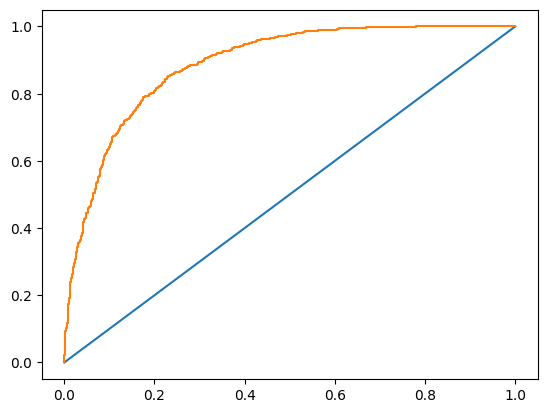

In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print("AUC score:", roc_auc_score(y_test, y_pred))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
# print("Thresh:", thresh)
# print("FPR, TPR", fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)

In [ ]:
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape)
np.unique(y_pred)

(1550, 1)


array([0, 1])

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       884
           1       0.76      0.80      0.78       666

    accuracy                           0.80      1550
   macro avg       0.80      0.80      0.80      1550
weighted avg       0.81      0.80      0.80      1550



<Axes: >

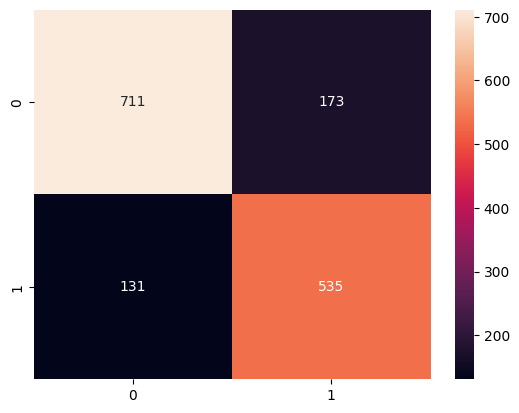

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred.astype(int)))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred.astype(int))
sns.heatmap(cm, annot=True, fmt="g")